In [1]:
tstart_utc="2023-05-18T12:59:08.000000"
duration_days=10.01
target_loc="healpix"
target_ra=83.01
target_dec=22.02
target_radius=1.
# target_healpix_url="https://gracedb.ligo.org/api/superevents/S230518h/files/bayestar.multiorder.fits"
target_healpix_url="bayestar.multiorder.fits"
enable_esac=1

In [32]:
from astropy.table import QTable
from astropy import units as u
import astropy_healpix as ah
import numpy as np
import integralvisibility
from matplotlib import pylab
from astropy.coordinates import SkyCoord


failed to get AUTH with env due to: 'K8S_SECRET_INTEGRAL_CLIENT_SECRET'
got AUTH with homefile for integral-limited


2023-05-18 16:57:12 savchenk-NG-VN7-793G-79EG healpy[634803] WARNING setting the output map dtype to [dtype('float64')]


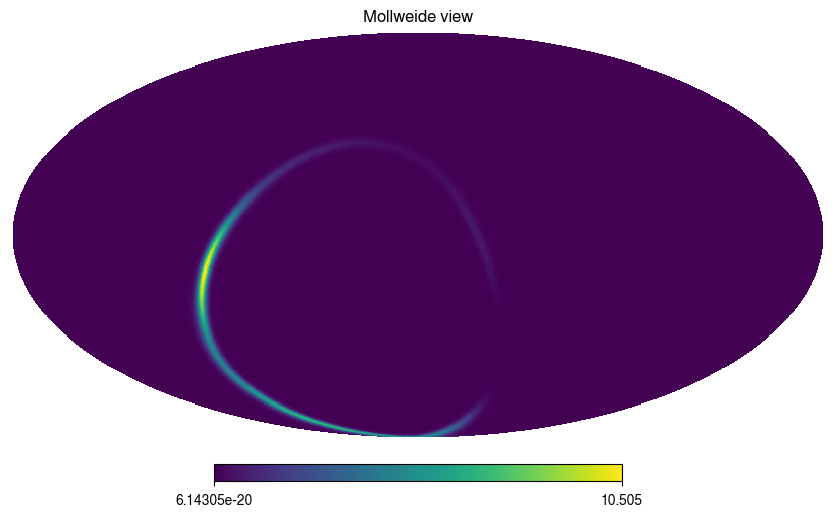

In [34]:
skymap = QTable.read('bayestar.multiorder.fits')
skymap

import ligo.skymap.moc
import healpy

d = ligo.skymap.moc.rasterize(skymap, order=8)

healpy.write_map('skymap.fits', d['PROBDENSITY'], nest=True)

healpy.mollview(d['PROBDENSITY'], nest=True)


2023-05-18 16:57:48 savchenk-NG-VN7-793G-79EG healpy[634803] INFO NSIDE = 256
2023-05-18 16:57:48 savchenk-NG-VN7-793G-79EG healpy[634803] INFO ORDERING = NESTED in fits file
2023-05-18 16:57:48 savchenk-NG-VN7-793G-79EG healpy[634803] INFO INDXSCHM = IMPLICIT
2023-05-18 16:57:48 savchenk-NG-VN7-793G-79EG healpy[634803] INFO Ordering converted to RING


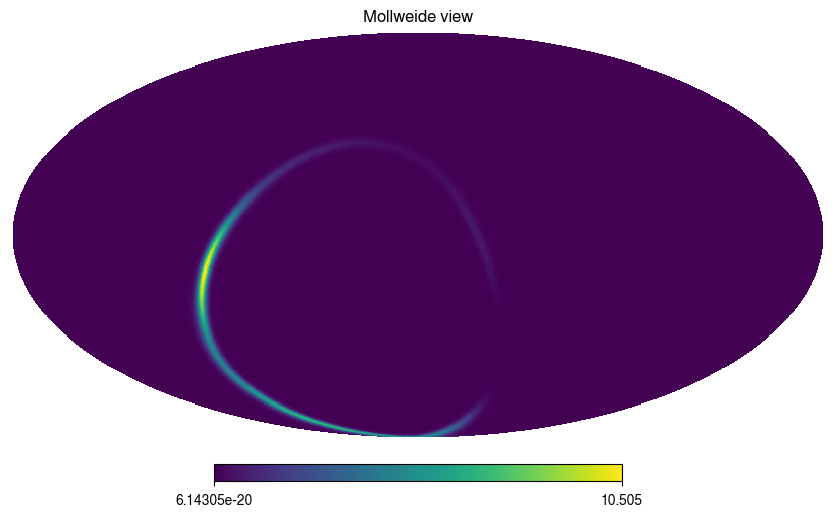

In [37]:
target_mp = healpy.read_map('skymap.fits')
healpy.mollview(target_mp)

In [3]:
import integralclient as ic
import datetime

if tstart_utc == "unknown":
    tstart_utc = datetime.datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%S")

tstart_ijd = float(ic.converttime("UTC",tstart_utc,"IJD"))

tstop_ijd = tstart_ijd+duration_days

2023-05-18 16:43:39 savchenk-NG-VN7-793G-79EG root[633230] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2023-05-18T12:59:08.000000/IJD


In [4]:
# %matplotlib notebook

In [5]:
vis = integralvisibility.Visibility(minsolarangle=40)
vis.minsolarangle=40

2023-05-18 16:43:40 savchenk-NG-VN7-793G-79EG root[633230] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2002-01-01T00:00:00/IJD
2023-05-18 16:43:41 savchenk-NG-VN7-793G-79EG root[633230] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2012-01-01T00:00:00/IJD


In [6]:
mp=vis.for_time(tstart_ijd,nsides=128)



2023-05-18 16:43:42 savchenk-NG-VN7-793G-79EG root[633230] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/ANY/8538.5418655555549776/IJD


get grid...
sun coord <SkyCoord (ICRS): (ra, dec) in deg
    (53.40337841, 19.21390361)>
will compute map.. (196608,)


In [7]:
sc = ic.get_sc(tstart_utc)
sc

{'barytime': -0.13204211416988895,
 'bodies': {'earth': {'body_dec': -73.32,
   'body_distance': 0,
   'body_in_sc': [40.25729041882267, -36.39325017874631],
   'body_ra': 17.826999999999998,
   'body_size': 2.517956390525901,
   'integral_parallax': 57.29577951308232,
   'separation': 144971.3},
  'moon': {'body_dec': -73.32,
   'body_distance': 382761.4820532454,
   'body_in_sc': [76.3506718379849, -6.236353132391373],
   'body_ra': 17.826999999999998,
   'body_size': 0.24511056184196148,
   'integral_parallax': 20.45710811396635,
   'separation': 406032.15245531814},
  'sun': {'body_dec': -73.32,
   'body_distance': 151310844.76351023,
   'body_in_sc': [88.9474245603435, -0.8261699075410156],
   'body_ra': 17.826999999999998,
   'body_size': 0.26346217626118407,
   'integral_parallax': 0.05490075347622968,
   'separation': 151295621.91020304}},
 'd_scx': 40.25729041882267,
 'd_scy': 112.54559514218083,
 'd_scz': 58.65520960645785,
 'dyz_scy': 126.39325017874631,
 'dyz_scz': 36.39325

In [8]:
sc['bodies']['earth']['body_ra']

17.826999999999998

In [9]:
now_point = SkyCoord(sc['scx']['ra'], sc['scx']['dec'], unit='deg')
now_point

<SkyCoord (ICRS): (ra, dec) in deg
    (321.535, 12.925)>

In [10]:
import requests

#http://integral.esac.esa.int/isocweb/tvp.html?revolution=2050&action=perRevolution
r=requests.get("http://integral.esac.esa.int/isocweb/tvp.html",
            params=dict(
                    startDate=tstart_utc[8:10]+"-"+tstart_utc[5:7]+"-"+tstart_utc[:4],                    
                    duration="12.600",
                    dither="R",
                    action="predict",
                    endDate="31-12-2019",
                    coordinates="equatorial",
                    ra=target_ra,
                    dec=target_dec,
                    format="json"))

try:
    if not enable_esac: raise RuntimeError
    
    visibility = r.json()
    
    #visibility
    pylab.figure()

    for interval in visibility['INTERVALS'][:10]:
        print(interval)
        i1=float(ic.converttime("UTC",interval['start'][:-4].replace(" ","T"),"IJD"))
        i2=float(ic.converttime("UTC",interval['end'][:-4].replace(" ","T"),"IJD"))

        print(i1,i2)

        pylab.axvspan(i1,i2,alpha=0.5)

    pylab.axvspan(tstart_ijd,tstop_ijd,alpha=0.5,color='g')
    pylab.xlabel("IJD")

    pylab.savefig('visibility_intervals.png')

except:
    print(r.text)









<html>
<head>
    <title>Target Visibility Predictor</title>
    <link type="text/css" rel="stylesheet" href="javascript/js9support.css">
    <link type="text/css" rel="stylesheet" href="javascript/js9.css">

    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css">
    <script type="text/javascript" src="javascript/js9prefs.js"></script>
    <script type="text/javascript" src="javascript/js9support.min.js"></script>
    <script type="text/javascript" src="javascript/js9.min.js"></script>
    <script type="text/javascript" src="javascript/js9plugins.js"></script>
    <script type="text/javascript">
        function show() {

        }
    </script>
    <style type="text/css">
        #centerdiv {
            width: 100%;
        / / margin-left: auto;
        / / margin-right: auto;
        }

        #JS9ToolbarToolbar {
            width: 516px;
            height: 144px;
            min-height: 30px;
        }

        .JS9Toolba

In [11]:
import requests

esac_visibility_rev = ic.converttime('UTC',tstart_utc,'REVNUM')

print("will fetch ESOC visibility map for rev",esac_visibility_rev)

try:
    r=requests.get("http://integral.esac.esa.int/isocweb/tvp.html",
            params=dict(
                    revolution=esac_visibility_rev,
                    action='perRevolution',
                    ))

    esac_visibility_map = r.json()
    print("ESAC VM success")
except:
    esac_visibility_map = None
    print("ESAC visibility failed:", r.text)

#visibility




2023-05-18 16:43:44 savchenk-NG-VN7-793G-79EG root[633230] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2023-05-18T12:59:08.000000/REVNUM


will fetch ESOC visibility map for rev 2641
ESAC VM success


In [12]:
import healpy

import numpy as np

mp_ra, mp_dec = integralvisibility.healpy.pix2ang(128,range(integralvisibility.healpy.nside2npix(128)),lonlat=True)

esac_mp = np.zeros_like(mp_ra)

try:
    if not enable_esac: raise RuntimeError
    for sky_bin in esac_visibility_map['sky_bins'][:10000]:
        #print(sky_bin)

        m = (mp_ra > float(sky_bin['top_left_corner'][0])) & (mp_ra < float(sky_bin['top_right_corner'][0]))
        m &= (mp_dec < float(sky_bin['top_left_corner'][1])) & (mp_dec > float(sky_bin['bottom_left_corner'][1]))

        esac_mp[m]=float(sky_bin['duration'])
except Exception as e:
    print("ESAC visibility failed:", e)
    esac_mp = mp



In [15]:
!wget $target_healpix_url
healpy.read_map(target_healpix_url)


--2023-05-18 16:45:06--  https://gracedb.ligo.org/api/superevents/S230518h/files/bayestar.multiorder.fits
Resolving gracedb.ligo.org (gracedb.ligo.org)... 100.21.214.239, 52.25.57.90, 44.225.177.158
Connecting to gracedb.ligo.org (gracedb.ligo.org)|100.21.214.239|:443... connected.
HTTP request sent, awaiting response... ^C


timeout: The read operation timed out

In [13]:
import gzip

if target_loc == "healpix":
    from io import BytesIO
    from astropy.io import fits
    
    # c = requests.get(target_healpix_url).content
    # try:
    #     b = gzip.open(BytesIO(c))
    #     b.seek(0)
    #     f = fits.open(b)
    # except:
    #     f = fits.open(BytesIO(c))
        
    # target_mp = healpy.read_map(f[1])
    
    healpy.mollview(target_mp)
    
    target_mp = healpy.get_interp_val(target_mp, mp_ra, mp_dec, lonlat=True)
    target_mp/=target_mp.sum()

    healpy.mollview(target_mp)
    
    indices = np.argsort(-target_mp)
    target_cum_map = np.empty(target_mp.shape)
    target_cum_map[indices] = 100 * np.cumsum(target_mp[indices])

    healpy.mollview(target_cum_map)

    extract={}
    
    for k,v in dict(f[1].header).items():    
        if k.startswith('LOG') or \
           k.startswith('DIST') or \
           k.startswith('INSTRUME'):
            extract[k] = v
            print(k,v)
else:
    extract={}
    
extract

2023-05-18 16:44:07 savchenk-NG-VN7-793G-79EG healpy[633230] INFO No NSIDE in the header file : will use length of array
2023-05-18 16:44:07 savchenk-NG-VN7-793G-79EG healpy[633230] INFO NSIDE = 40
2023-05-18 16:44:07 savchenk-NG-VN7-793G-79EG healpy[633230] INFO ORDERING = NUNIQ in fits file
2023-05-18 16:44:07 savchenk-NG-VN7-793G-79EG healpy[633230] INFO INDXSCHM = EXPLICIT


IndexError: index 34952 is out of bounds for axis 0 with size 19200

In [ ]:
def total_slew_time_s(distance_deg):
    total_slew_options = []
    
    slew_duration_s = distance_deg*60*60/185.
    
    total_slew_options.append(slew_duration_s)
    
    if distance_deg>45:
        rwb_duration_s = 22*60. 
        total_slew_options.append(slew_duration_s + rwb_duration_s)
    
    return total_slew_options

def total_reaction_time_s(distance_deg):
    return [ (x + 3600*2) for x in total_slew_time_s(distance_deg)]
    
total_reaction_time_s(10),total_reaction_time_s(50)

In [ ]:
visibility_summary = {}

for kind, vismp in [("std", mp), ("esac", esac_mp)]:
    visibility_summary[kind]={}
    vis = visibility_summary[kind]
    
    nsides = healpy.npix2nside(len(vismp))

  #  integralvisibility.healpy.mollview(vismp,title="INTEGRAL visibility at "+tstart_utc[:19],cbar=False)
  #  integralvisibility.healpy.graticule()
  #  pylab.savefig("visibility_"+kind+".png")

    radec=integralvisibility.healpy.pix2ang(integralvisibility.healpy.npix2nside(len(vismp)), range(len(vismp)), lonlat=True)
    ra,dec=radec
    
    sep_from_now_deg = np.transpose(SkyCoord(*radec,unit='deg').separation(now_point).deg)
    
    dist_ra=(ra - target_ra)
    dist_ra[abs(dist_ra)>180]-=360

    if target_loc == "point":
        
            target_mp=np.exp(
                -0.5*(dist_ra/target_radius)**2  \
                -0.5*((dec - target_dec)/target_radius )**2
            )

            target_mp/=np.sum(target_mp)
        
      
        

    integralvisibility.healtics.plot_with_ticks((vismp/vismp.max())*100, 
                                                overplot=[[(target_mp,'r',target_mp.max()/10.)]],
                                                vmin=0,
                                                cmap="summer",
                                                unit="%",
                                                title="INTEGRAL visibility at "+tstart_utc[:19])

#     integralvisibility.healpy.mollview(vismp/vismp.max() + target_mp/target_mp.max(),title="INTEGRAL visibility at "+tstart_utc[:19],cbar=False)
#     integralvisibility.healpy.graticule()

    vis['on_peak'] = vismp[target_mp.argmax()]
    vis['on_peak_frac'] = vis['on_peak'] / vismp.max()

    vis['on_probability'] = target_mp[vismp > vismp.max()/2.].sum()

    #vis['visible_peak_ra'] = healpy.pix2ang(nsides, target_mp[vismp > vismp.max()/2.].argmax(),)
    vis['visible'] = vis['on_probability']
    
    def argmax_masked(x,y):
        mi = x[y].argmax()
        print("mi",mi)
        idx = np.array(range(len(x)))
        print("idx",idx)
        return idx[y][mi]

    vis['peak_of_target'] = list(np.transpose(radec)[target_mp.argmax()])
    vis['peak_of_visible'] = list(np.transpose(radec)[argmax_masked(target_mp, vismp > vismp.max()/2.)])


    vis['points'] = [
        dict(descr="total visble",prob=vis['on_probability']),
        dict(descr="peak",ra=vis['peak_of_target'][0],dec=vis['peak_of_target'][1]),
        dict(descr="visible peak",ra=vis['peak_of_visible'][0],dec=vis['peak_of_visible'][1]),
    ]
    
    
    colors=['r','m','k','b','g','c','y','w','grey']
    for limrange in None, 45, 90:
        
        limmod = "lim%.3lgdeg_"%limrange if limrange is not None else ""
        limdescr = " (%.3lg deg from now)"%limrange if limrange is not None else ""
        
        
        for scale, descr in [(5, "best for staring"), (15, "best for HEX"), (30, "best for 5x5")]:
            c=colors.pop()
            target_sm = healpy.smoothing(target_mp/target_mp.max(), sigma=scale/180.*np.pi,verbose=False)
            target_sm/=sum(target_sm)

            print(sum(target_sm),sum(target_mp))
                        
            mask_visible = (vismp > vismp.max()/2.)
            if limrange is not None:
                mask_visible &= (sep_from_now_deg < limrange)
                
            vis[limmod+'best_visible_%ideg'%scale]=list(np.transpose(radec)[argmax_masked(target_sm, mask_visible)])
            vis[limmod+'best_visible_prob_%ideg'%scale]=max(target_sm[mask_visible])*scale*scale*4*np.pi*2  

            true_peak = SkyCoord(vis['peak_of_target'][0],vis['peak_of_target'][1],unit="deg")

            vis['points'] += [dict(
                alt_descr="peak at %i deg scale"%scale+limdescr,            
                descr = descr+limdescr,            
                ra=vis[limmod+'best_visible_%ideg'%scale][0],
                dec=vis[limmod+'best_visible_%ideg'%scale][1],
                prob=vis[limmod+'best_visible_prob_%ideg'%scale],
                distance_to_true_peak_deg=SkyCoord(vis[limmod+'best_visible_%ideg'%scale][0], vis[limmod+'best_visible_%ideg'%scale][1],unit="deg").separation(true_peak).deg,
                distance_to_now=SkyCoord(vis[limmod+'best_visible_%ideg'%scale][0], vis[limmod+'best_visible_%ideg'%scale][1],unit="deg").separation(now_point).deg
            )]


            def c_ra(x):
                if x<180:
                    return -x
                return 360-x

            pylab.scatter(
                c_ra(vis[limmod+'best_visible_%ideg'%scale][0])/180.*np.pi,
                vis[limmod+'best_visible_%ideg'%scale][1]/180.*np.pi,
                s=100,c=c)

            pylab.text(
                c_ra((-5+vis[limmod+'best_visible_%ideg'%scale][0]))/180.*np.pi,
                (5+vis[limmod+'best_visible_%ideg'%scale][1])/180.*np.pi,
                "%i deg"%scale,
                size=10,color=c)
        
    
    pylab.scatter(
        c_ra(sc['scx']['ra'])/180.*np.pi,
        sc['scx']['dec']/180.*np.pi,
        marker='x',
        s=200,c='k',
        label='FoV')
    
    #pylab.legend()

    

        
    print(visibility_summary)


    pylab.savefig("skymap_visibility_"+kind+".png")

In [ ]:
visibility_summary['esac']

In [ ]:
template="""
<html>
<head>
</head>
<body>

<table style="border-collapse: separate;border-spacing: 2px;">


<tr style="background-color:#ADD8E6">
<td align="center"></td>
<td align="center">RA</td>
<td align="center">Dec</td>
<td align="center">Probability</td>
<!--<td align="center">To Peak</td>-->
<td align="center">From current</td>
</tr>

{% for point in points %}

<tr>
<td style="text-align:center" >
<div data-toggle="{{ point.uid }}_loc_tooltip" title="{{ point.alt_descr }}" style="display:inline-block;margin-right:10px;">
{{ point.descr }}
</div>
</td>

{% if point.ra %}
<td style="text-align:center" >{{ point.ra | round(1) }}</td>
<td style="text-align:center" >{{ point.dec | round(1)}}</td>
{% else %}
<td style="text-align:center" ></td>
<td style="text-align:center" ></td>
{% endif %}

{% if point.prob %}
<td style="text-align:center" >{{ (100*point.prob) | round(1)}}%</td>
{% else %}
<td style="text-align:center" ></td>
{% endif %}

<!--
{% if point.distance_to_true_peak_deg %}
<td style="text-align:center" >{{ point.distance_to_true_peak_deg | round(1)}} deg</td>
{% else %}
<td style="text-align:center" ></td>
{% endif %}
-->


{% if point.distance_to_now %}
<td style="text-align:center" >{{ point.distance_to_now | round(1)}} deg</td>
{% else %}
<td style="text-align:center" ></td>
{% endif %}


</tr>

{% endfor %}

<tr style="background-color:#ADD8E6">
<td colspan=5 height="5px"></td>
</tr>


</table>

</body>
</html>
"""

from IPython.core.display import display, HTML
from jinja2 import Environment, BaseLoader

rtemplate = Environment(loader=BaseLoader).from_string(template)


data_html = rtemplate.render(points=visibility_summary['esac']['points'])

open("visibility_card.html","w").write(data_html)

display(HTML(data_html))

In [ ]:
visibility_fraction=visibility_summary['esac']['visible']

In [ ]:
skymap_png="skymap_visibility_std.png"
skymap_esac_png="skymap_visibility_esac.png"
visibility_std="visibility_std.png"
visibility_esac="visibility_esac.png"
visibility_intervals_png='visibility_intervals.png'
visibility_summary=visibility_summary
visibility_fraction=visibility_fraction
visibility_card="visibility_card.html"
extract=extract